In [1]:
# Import machine-learning packages
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np
import random

%matplotlib inline
import xarray as xr
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
from google.colab import auth
auth.authenticate_user()
import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()

Mounted at /content/drive/


# Creating Data-Sets

In [2]:
import glob

flist = glob.glob("/content/drive/MyDrive/ictp2024_icepack_project/training/*.20*0101.nc")
print(flist)

['/content/drive/MyDrive/ictp2024_icepack_project/training/Antarctica.sit2.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Arctic.sit2.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Arctic.sit2.20110101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Arctic.sit2.20120101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Arctic.sit1.20120101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Arctic.sit1.20110101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Arctic.sit1.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Antarctica.sit1.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Antarctica.1it.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Antarctica.2it.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/Antarctica.0it.20090101.nc', '/content/drive/MyDrive/ictp2024_icepack_project/training/

In [3]:
import pandas as pd

datasets = []
i_init = 1

for file_path in flist:
    ds = xr.open_dataset(file_path, decode_times=False)
    time = ds['time']
    time_values = pd.to_datetime(time.values)
    new_time_values = [i for i in np.arange(i_init, len(time)+i_init)]
    new_time = xr.DataArray(new_time_values, dims='time', coords={'time': new_time_values})
    ds = ds.assign_coords(time=new_time)
    datasets.append(ds)
    i_init += len(time)

combined_ds = xr.concat(datasets, dim='time')

# Close all datasets
for ds in datasets:
    ds.close()
combined_ds.close()

In [4]:
combined_ds

<xarray.Dataset> Size: 925MB
Dimensions:   (time: 166440, ni: 4, ncat: 5, ntrcr: 21)
Coordinates:
  * ni        (ni) int32 16B 1 2 3 4
  * ncat      (ncat) int32 20B 1 2 3 4 5
  * ntrcr     (ntrcr) int32 84B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21
  * time      (time) int64 1MB 1 2 3 4 5 ... 166436 166437 166438 166439 166440
Data variables: (12/39)
    timestep  (time) int32 666kB 1 2 3 4 5 6 7 ... 8755 8756 8757 8758 8759 8760
    date      (time) float64 1MB 2.015e+07 2.015e+07 ... 2.015e+07 2.016e+07
    aice      (time, ni) float64 5MB 0.0 0.9999 0.9999 0.0 ... 0.9999 0.9999 0.0
    vice      (time, ni) float64 5MB 0.0 2.001 1.795 0.0 ... 0.9966 0.9658 0.0
    vsno      (time, ni) float64 5MB 0.0 0.0 0.2175 0.0 ... 0.0954 0.1068 0.0
    uvel      (time, ni) float64 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...        ...
    fhocn     (time, ni) float64 5MB 0.0 -6.829 -12.6 0.0 ... -3.198 -3.137 0.0
    aicen     (time, ncat, ni) float64 27MB 0.0 0.0 0.09942 ... 0.004224 0.0
    vicen     (time, ncat, ni) float64 27MB 0.0 0.0 0.03011 ... 0.02483 0.0
    vsnon     (time, ncat, ni) float64 27MB 0.0 0.0 0.005966 ... 0.001064 0.0
    trcr      (time, ntrcr, ni) float64 112MB -1.905 -7.001 -8.812 ... 0.0 0.0
    trcrn     (time, ncat, ntrcr, ni) float64 559MB -1.905 -1.905 ... 0.0 0.0

In [42]:
data = combined_ds
input_vars = ["vice", "sst", "sss", "Tair", "Qa", "frain", "fsnow", "flw", "fsw"]
data_x = []
for var in input_vars:
    data_x += [data[var].values[:-1, 2]]

data_y = data.vice.values[1:,2] - data.vice.values[:-1,2]

## Partitioning Data

In [7]:
num_t = len(data_x[0])
ind = np.arange(num_t)
train_prop, val_prop, test_prop = 0.7, 0.15, 0.15

# 10 days train, 2 days validation, 2 days test
index_train = [i for i in ind if i % (14 * 24) in np.arange(10 * 24)]
index_val = [i for i in ind if i % (14 * 24) in np.arange(10 * 24, 12 * 24)]
index_test = [i for i in ind if i % (14 * 24) in np.arange(12 * 24, 14 * 24)]

print("Train, first and last: ", [index_train[0], index_train[-1]])
print("Validation, first and last: ", [index_val[0], index_val[-1]])
print("Test, first and last: ", [index_test[0], index_test[-1]])
print("Train set size: ", len(index_train))
print("Validation set size: ", len(index_val))
print("Test set size: ", len(index_test))
print("Sum of sizes:", sum([len(index_train), len(index_val), len(index_test)]))

# shuffle training and validation sets in place
random.shuffle(index_train)
random.shuffle(index_val)

Train, first and last:  [0, 166438]
Validation, first and last:  [240, 166271]
Test, first and last:  [288, 166319]
Train set size:  118919
Validation set size:  23760
Test set size:  23760
Sum of sizes: 166439


### Creating Training Set

In [43]:
epsilon = 1e-8  # Small constant
lnorm = True
lbatch = False

In [44]:
n = len(index_train)
x = torch.ones(n,9)
y = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x[i][j]= data_x[j][index_train[i]]
    y[i] = data_y[index_train[i]]

#y = (y - torch.mean(y)) / (torch.std(y) + epsilon)

In [45]:
if lnorm:
    std = []
    mean = []

    for i in range(9):
        std.append(torch.std(x[:,i]))
        mean.append(torch.mean(x[:,i]))
        x[:,i] = (x[:,i] - mean[i]) / (std[i] + epsilon)

### Creating Validation Set

In [46]:
n = len(index_val)
x_val = torch.ones(n,9)
y_val = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x_val[i][j]= data_x[j][index_val[i]]
    y_val[i] = data_y[index_val[i]]

#y_val = (y_val - torch.mean(y_val)) / (torch.std(y_val) + epsilon)

In [47]:
if lnorm:
    std_val = std
    mean_val = mean

    for i in range(9):
    #    std_val.append(torch.std(x_val[:,i]))
    #    mean_val.append(torch.mean(x_val[:,i]))
        x_val[:,i] = (x_val[:,i] - mean_val[i]) / (std_val[i] + epsilon)

Check if normalized or not:

In [48]:
print(min(x[:,0]), max(x[:,0]))

tensor(-1.2715) tensor(2.7319)


In [49]:
import torch.utils.data as Data

In [50]:
# CAN PLAY AROUND W/ # OF BATCHES/BATCH SIZES
n_batches = 4
BATCH_SIZE = int(np.floor(len(x) / n_batches))
print(BATCH_SIZE)

local_dataset = Data.TensorDataset(x,y)

local_loader_train = Data.DataLoader(
    dataset=local_dataset, batch_size=BATCH_SIZE, shuffle=True
)

29729


In [51]:
local_dataset_val = Data.TensorDataset(x_val,y_val)

local_loader_val = Data.DataLoader(
    dataset=local_dataset_val, batch_size=BATCH_SIZE, shuffle=False
)

# Defintion Neural Network

In [52]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(9, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x

class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(9, 30)
        self.linear2 = nn.Linear(30, 40)
        self.linear3 = nn.Linear(40, 20)
        self.linear4 = nn.Linear(20, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x


In [53]:
#neural_net = Simple_Neural_Net()

In [54]:
neural_net = FCNN()

In [55]:
# Here we use the Adam optimizer.
learning_rate = 0.001 #0.005
optimizer = torch.optim.Adam(neural_net.parameters())

In [56]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

# Training

In [57]:
def train_step(model, loss_fn, optimizer):
    model.train()
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

In [58]:
def train_step_batch(model, loss_fn, optimizer, loader):
    model.train()
    train_loss = 0
    for batch_x, batch_y in loader:
        # Get predictions
        if len(batch_x.shape) == 1:
            # This if block is needed to add a dummy dimension if our inputs are 1D
            # (where each number is a different sample)
            prediction = torch.squeeze(model(torch.unsqueeze(batch_x, 1)))
        else:
            prediction = model(batch_x)

        # Compute the loss
        loss = loss_fn(prediction, batch_y)
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step()

    return train_loss / len(loader)

In [59]:
def validate_step(model, loss_fn):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x_val)
    loss = loss_fn(pred, y_val)

    loss = loss.item()
    return loss

In [60]:
def validate_step_batch(model, loss_fn, loader):
    model.eval()  # Evaluation mode (important when having dropout layers)

    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            # Get predictions
            if len(batch_x.shape) == 1:
                # This if block is needed to add a dummy dimension if our inputs are 1D
                # (where each number is a different sample)
                prediction = torch.squeeze(model(torch.unsqueeze(batch_x, 1)))
            else:
                prediction = model(batch_x)

            # Compute the loss
            loss = loss_fn(prediction, batch_y)
            val_loss += loss.item()

        # Get an average loss for the entire dataset
        val_loss /= len(loader)

    return val_loss

In [61]:
if lbatch:
    # TRAIN MODEL, WITH BATCHES
    epochs = 1000
    Loss = np.zeros(epochs)
    V_Loss = np.zeros(epochs)
    for t in range(epochs):
        Loss[t] = train_step_batch(neural_net, loss_fn, optimizer, local_loader_train)
        V_Loss[t] = validate_step_batch(neural_net, loss_fn, local_loader_val)
        if np.mod(t, 200) == 0:
            print(f"Loss at Epoch {t+1} is ", Loss[t])
else:
    epochs = 1000
    Loss = np.zeros(epochs)
    V_Loss = np.zeros(epochs)
    for t in range(epochs):
        Loss[t] = train_step(neural_net, loss_fn, optimizer)
        V_Loss[t] = validate_step(neural_net, loss_fn)
        if np.mod(t, 200) == 0:

            print(f"Loss at Epoch {t+1} is ", Loss[t])

Loss at Epoch 1 is  0.004535127896815538
Loss at Epoch 201 is  8.935952791944146e-05
Loss at Epoch 401 is  8.717455057194456e-05
Loss at Epoch 601 is  8.650546078570187e-05
Loss at Epoch 801 is  8.620866719866171e-05


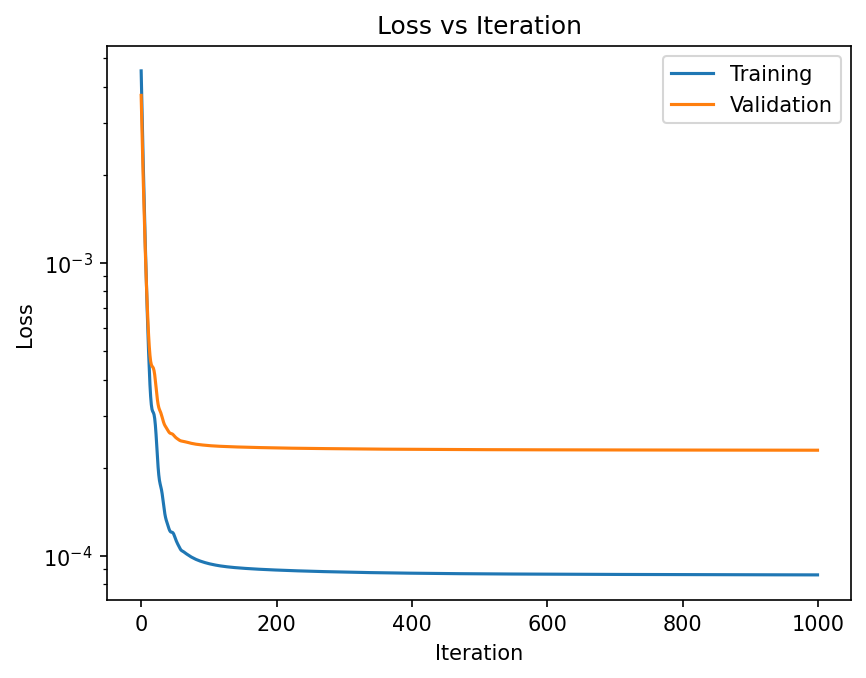

In [62]:
plt.figure(dpi=150)
plt.plot(Loss, label = "Training")
plt.plot(V_Loss, label = "Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.legend()
plt.show()

# Testing

### Creating Test-Data-Set

In [63]:
data_t = xr.open_dataset("/content/drive/MyDrive/ictp2024_icepack_project/testing/Arctic.0it.20120101.nc", decode_times=False)

In [64]:
len(data_t.time)

8760

In [72]:
n = 8000 #len(data_t.time)
y_ml_pred = torch.zeros(n+1)
xt = torch.ones(n,9)

data_xt = []
for var in input_vars:
    data_xt += [data_t[var].values[:n, 2]]

for i in range(n):
    for j in range(9):
        xt[i][j]= data_xt[j][i]

if lnorm:
    std_t = std
    mean_t = mean

    for i in range(9):
        #std_t.append(torch.std(xt[:,i]))
        #mean_t.append(torch.mean(xt[:,i]))
        #if i > 0:
        xt[:,i] = (xt[:,i] - mean_t[i]) / (std_t[i] + epsilon)

# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.

y_ml_pred = torch.zeros(n+1)
x_test = torch.ones(9)
for i in range(n):
    for j in range (1,9):  # to avoid writing in the place of predicted field
        x_test[j] = xt[i,j]
    if i == 0:
        x_test[0] = xt[0,0]
    else:
        x_test[0] = (xt[i-1,0] + pred - mean[0]) / (std[0] + epsilon)
    pred = neural_net(x_test).detach().numpy()
    pred = torch.from_numpy(pred)
    y_ml_pred[i+1] = pred

# store icepack output for comparison with predicted result
y_test = data_t.vice.values[1:,2] - data_t.vice.values[:-1,2]
#y_test = (y_test - np.mean(y_test)) / (np.std(y_test) + epsilon)

In [73]:
if False:
  n = len(index_test)
  xt = torch.ones(n,9)
  for i in range(n):
      for j in range(9):
          xt[i][j]= data_x[j][index_test[i]]

In [74]:
if False:
  plt.figure(dpi=150)
  plt.plot(xt[:,0], ".",markersize=0.5, label="test_norm")

  plt.legend()

In [75]:
if False:
  # Generate some points where the predictions of the model will be tested.
  # Here we pick the testing domain to be larger than the training domain to check if the model
  # has any skill at extrapolation.

  y_ml_pred = torch.zeros(len(index_test)+1)
  x_test = torch.ones(9)
  for i in range(len(index_test)):
      for j in range (1,9):  # to avoid writing in the place of predicted field
          x_test[j] = xt[i,j]
      if i == 0:
          x_test[0] = xt[0,0]
      else:
          x_test[0] = (pred - mean[0]) / (std[0] + epsilon)
      pred = neural_net(x_test).detach().numpy()
      pred = torch.from_numpy(pred)
      y_ml_pred[i+1] = pred

  # store icepack output for comparison with predicted result
  y_test = torch.ones(len(index_test))
  for i in range(len(index_test)):
      y_test[i] = data_y[index_test[i]] #- data_y[index_test[i-1]]

In [ ]:
#y_ml_pred
y_tice_pred =

## Comparing prediction to ICEPACK-Data

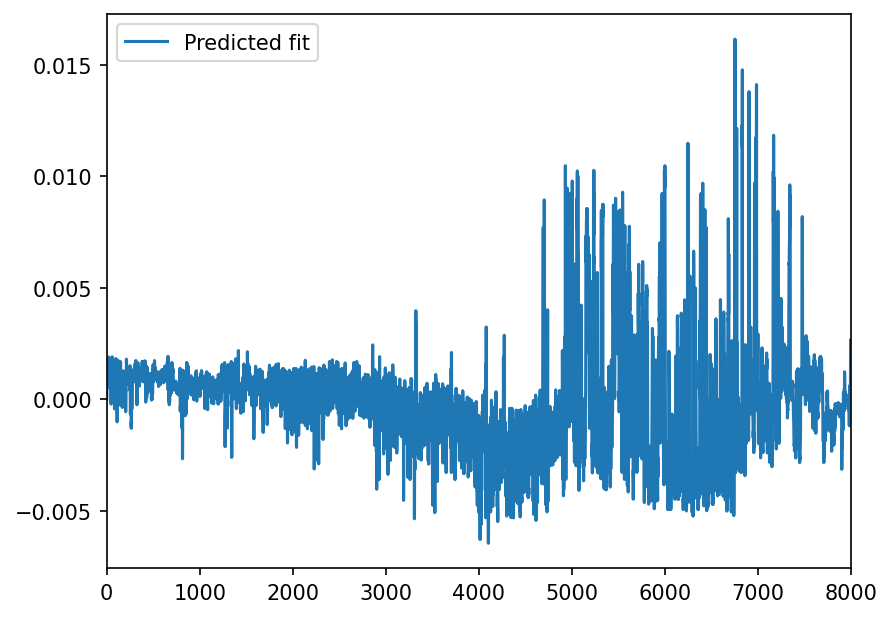

In [77]:
plt.figure(dpi=150)

#plt.plot(y_test, markersize=0.5, label="Icepack output")
plt.plot(y_ml_pred, markersize=0.5, label="Predicted fit")
plt.xlim(0,n)
plt.legend()

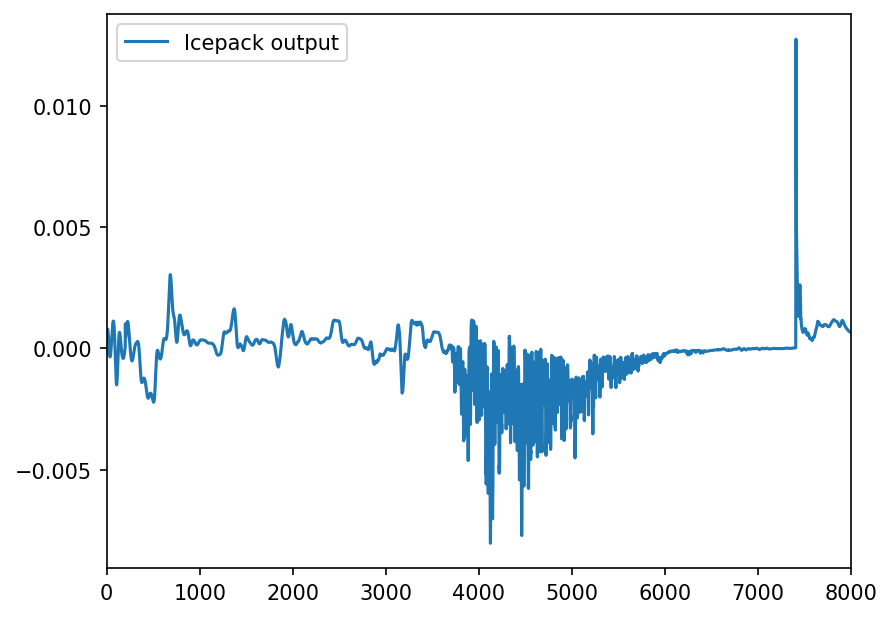

In [78]:
plt.figure(dpi=150)

plt.plot(y_test, markersize=0.5, label="Icepack output")
#plt.plot(y_ml_pred, markersize=0.5, label="Predicted fit")
plt.xlim(0,n)
plt.legend()

## Difference between prediction and ICEPACK-Data

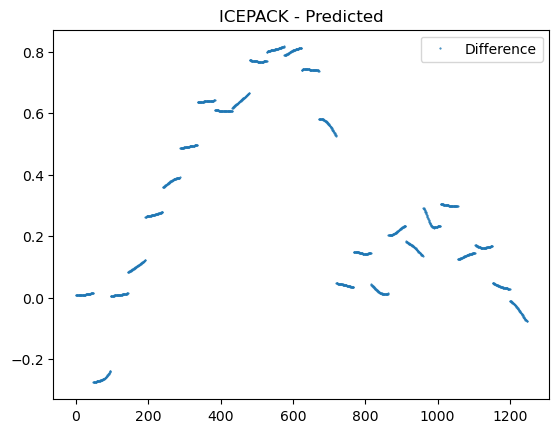

In [ ]:
plt.plot(y_test - pred.flatten(), 'o', markersize=0.5, label = 'Difference');
plt.title("ICEPACK - Predicted");
plt.legend();

# Validation